In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


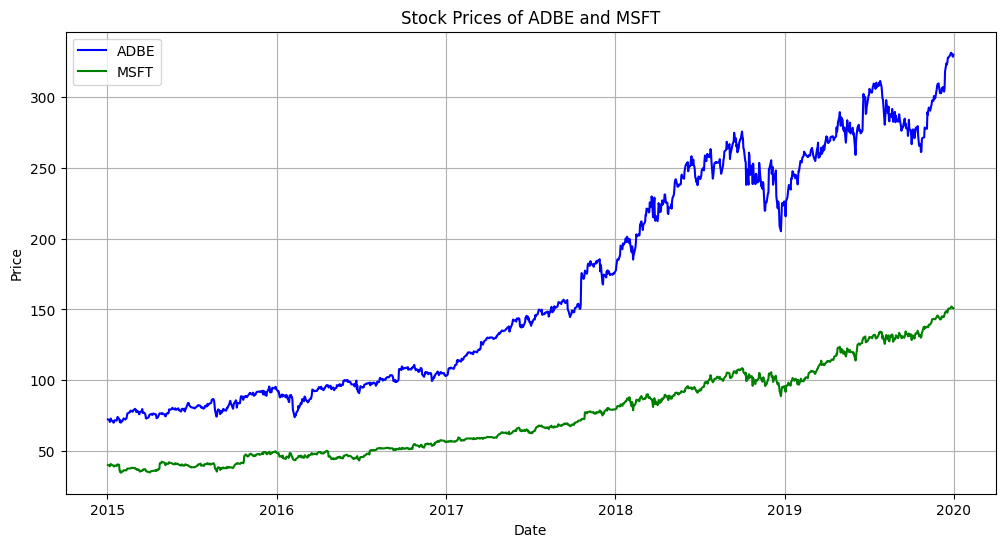

In [15]:
def fetch_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        raise ValueError(f"No data found for {ticker}")
    return data['Adj Close']

start_date = '2015-01-01'
end_date = '2020-01-01'

adbe = fetch_data('ADBE', start_date, end_date)
msft = fetch_data('MSFT', start_date, end_date)

# Plot raw stock prices
plt.figure(figsize=(12, 6))
plt.plot(adbe, label='ADBE', color='blue')
plt.plot(msft, label='MSFT', color='green')
plt.title('Stock Prices of ADBE and MSFT')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

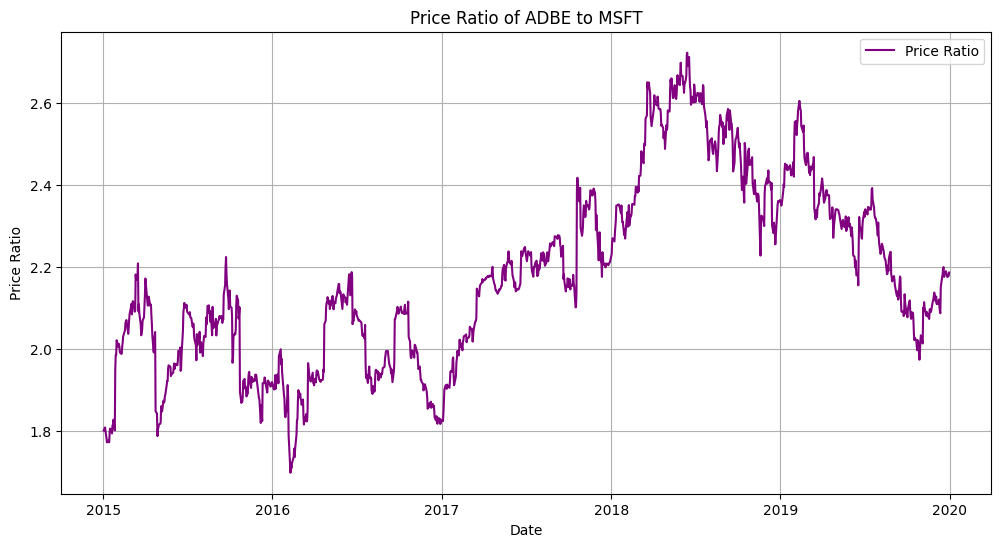

In [16]:
# Align indices of ADBE and MSFT to ensure they match
adbe = adbe.dropna()
msft = msft.dropna()
aligned_data = pd.concat([adbe, msft], axis=1).dropna()
aligned_data.columns = ['ADBE', 'MSFT']

# Compute Price Ratio
aligned_data['Price_Ratio'] = aligned_data['ADBE'] / aligned_data['MSFT']

data = aligned_data  # Use this for further steps

# Plot price ratio
plt.figure(figsize=(12, 6))
plt.plot(data['Price_Ratio'], label='Price Ratio', color='purple')
plt.title('Price Ratio of ADBE to MSFT')
plt.xlabel('Date')
plt.ylabel('Price Ratio')
plt.legend()
plt.grid()
plt.show()

In [17]:
data['5_MA'] = data['Price_Ratio'].rolling(5).mean()
data['20_MA'] = data['Price_Ratio'].rolling(20).mean()
data['60_MA'] = data['Price_Ratio'].rolling(60).mean()
data['ROC'] = data['Price_Ratio'].pct_change()
data['Volatility'] = data['Price_Ratio'].rolling(20).std()
data['Lag_1'] = data['Price_Ratio'].shift(1)
data = data.dropna()

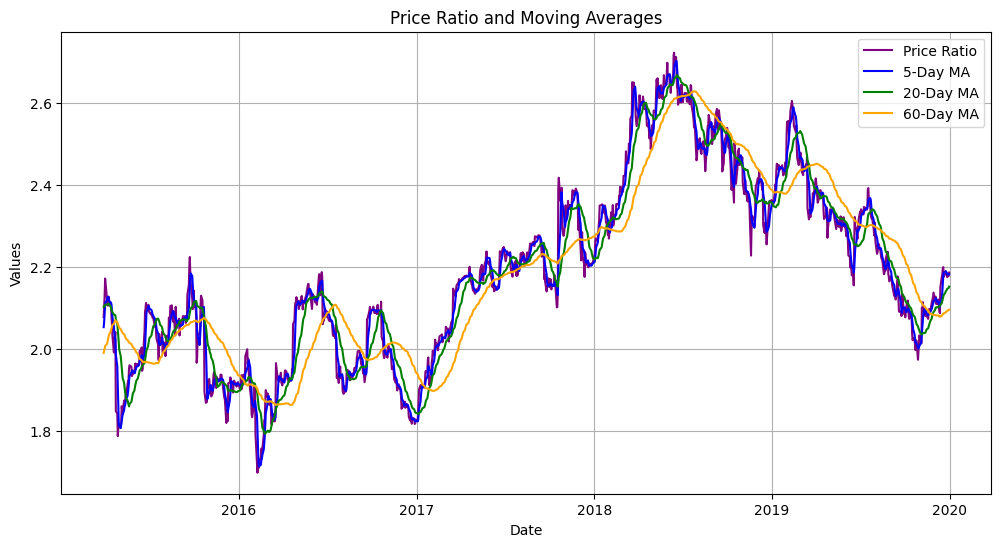

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(data['Price_Ratio'], label='Price Ratio', color='purple')
plt.plot(data['5_MA'], label='5-Day MA', color='blue')
plt.plot(data['20_MA'], label='20-Day MA', color='green')
plt.plot(data['60_MA'], label='60-Day MA', color='orange')
plt.title('Price Ratio and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

In [19]:
features = ['5_MA', '20_MA', '60_MA', 'ROC', 'Volatility', 'Lag_1']
target = 'Price_Ratio'
X = data[features]
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Multiple Machine Learning Models
models = {
    'Random Forest': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'Support Vector Regressor': SVR(),
    'K-Neighbors Regressor': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    results[name] = {'model': model, 'mse': mse}
    print(f'{name}: MSE = {mse}')

# Choose the best model based on MSE
best_model_name = min(results, key=lambda x: results[x]['mse'])
best_model = results[best_model_name]['model']
print(f'Best Model: {best_model_name}')

Random Forest: MSE = 0.00010173048699702892
Linear Regression: MSE = 4.585951052501927e-06
Support Vector Regressor: MSE = 0.0010381427025799158
K-Neighbors Regressor: MSE = 0.0003964056832965832
Decision Tree: MSE = 0.0002605928355150165
Best Model: Linear Regression


C:\Users\Hp\AppData\Local\Temp\ipykernel_32948\1408372443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predicted_Ratio'] = np.concatenate([np.full(len(data) - len(predicted_ratios), np.nan), predicted_ratios])
C:\Users\Hp\AppData\Local\Temp\ipykernel_32948\1408372443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'] = 0


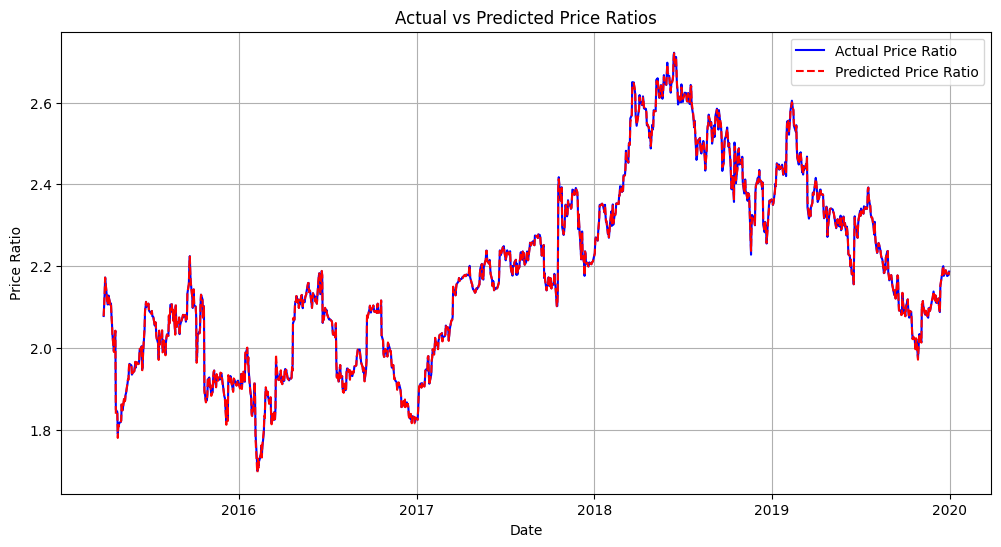

In [20]:
predicted_ratios = best_model.predict(X)
data['Predicted_Ratio'] = np.concatenate([np.full(len(data) - len(predicted_ratios), np.nan), predicted_ratios])
data['Signal'] = 0
data.loc[data['Predicted_Ratio'] > data['Price_Ratio'], 'Signal'] = -1  # Short ADBE, Long MSFT
data.loc[data['Predicted_Ratio'] < data['Price_Ratio'], 'Signal'] = 1   # Long ADBE, Short MSFT

# Plot predicted ratios vs actual ratios
plt.figure(figsize=(12, 6))
plt.plot(data['Price_Ratio'], label='Actual Price Ratio', color='blue')
plt.plot(data['Predicted_Ratio'], label='Predicted Price Ratio', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Price Ratios')
plt.xlabel('Date')
plt.ylabel('Price Ratio')
plt.legend()
plt.grid()
plt.show()


C:\Users\Hp\AppData\Local\Temp\ipykernel_32948\3921710205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PnL'] = data['Signal'] * (data['Price_Ratio'].pct_change())
C:\Users\Hp\AppData\Local\Temp\ipykernel_32948\3921710205.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cumulative_PnL'] = data['PnL'].cumsum()


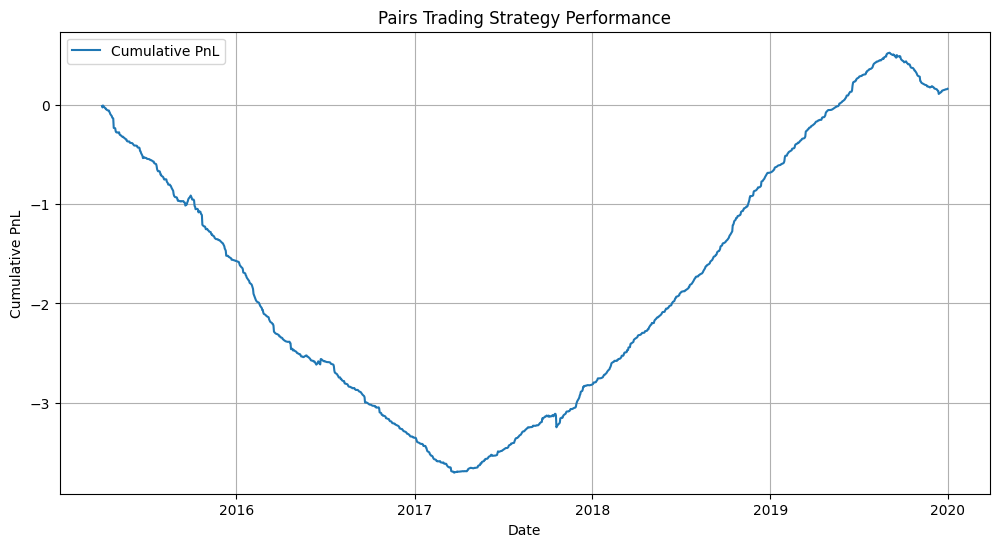

Final Cumulative PnL: 0.16147582740774824


In [21]:
data['PnL'] = data['Signal'] * (data['Price_Ratio'].pct_change())
data['Cumulative_PnL'] = data['PnL'].cumsum()

# Plot Cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Cumulative_PnL'], label='Cumulative PnL')
plt.title('Pairs Trading Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid()
plt.show()

# Summary of performance
final_pnl = data['Cumulative_PnL'].iloc[-1]
print(f'Final Cumulative PnL: {final_pnl}')


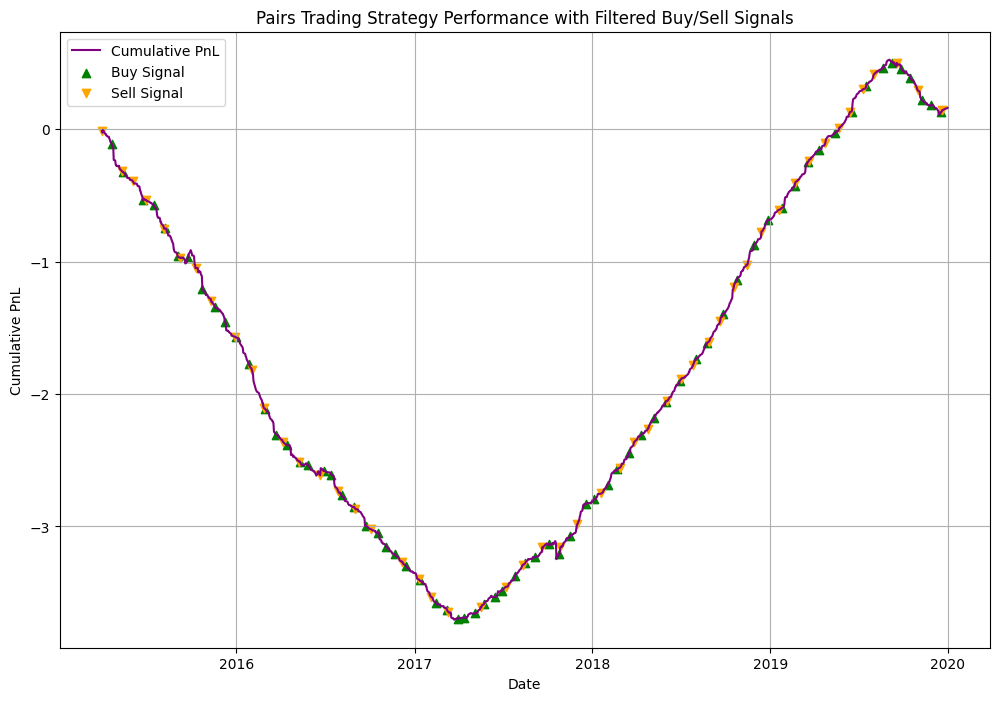

In [24]:
# Add Buy/Sell markers based on trading signals
buy_signals = data[data['Signal'] == 1]
sell_signals = data[data['Signal'] == -1]

buy_signals_filtered = buy_signals.iloc[::10]  # Show every 10th buy signal
sell_signals_filtered = sell_signals.iloc[::10]  # Show every 10th sell signal

plt.figure(figsize=(12, 8))  # Increase figure size for better visibility
plt.plot(data.index, data['Cumulative_PnL'], label='Cumulative PnL', color='purple')

# Mark filtered Buy and Sell signals on PnL graph
plt.scatter(buy_signals_filtered.index, buy_signals_filtered['Cumulative_PnL'], 
            label='Buy Signal', color='green', marker='^', alpha=1)
plt.scatter(sell_signals_filtered.index, sell_signals_filtered['Cumulative_PnL'], 
            label='Sell Signal', color='orange', marker='v', alpha=1)

plt.title('Pairs Trading Strategy Performance with Filtered Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid()
plt.show()
